In [2]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import string
import re
import nltk
import tensorflow as tf
from tensorflow import keras
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import class_weight
from keras.preprocessing.sequence import pad_sequences
from datetime import datetime
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from google.colab import files,drive
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
print("Running Panda Version:"+pd.__version__)
print("Running TensorFlow Version:"+ tf.__version__)
print("Running Keras API Version:"+ keras.__version__)
print("Running Python {0}.{1}".format(sys.version_info[:2][0],sys.version_info[:2][1]))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Running Panda Version:2.2.2
Running TensorFlow Version:2.17.0
Running Keras API Version:3.4.1
Running Python 3.10


In [3]:
seed = 0
np.random.seed(seed)

In [4]:
#drive.mount('/content/drive')

In [5]:
uploaded = files.upload()

Saving Tweets.csv to Tweets.csv


# ***Dataset Summary, Analysis and Cleaning***

In [6]:
dataset = pd.read_csv("Tweets.csv",na_values=['NA'], low_memory=False)

### Dataset shapes

In [7]:
print('Dataset structure: rows =',dataset.shape[0], ' - columns =',dataset.shape[1])

Dataset structure: rows = 14640  - columns = 15


### Some random rows

In [8]:
dataset.sample(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
13983,569682010270101504,negative,0.6163,Late Flight,0.6163,American,NaN,zsalim03,NaN,0,@AmericanAir In car gng to DFW. Pulled over 1h...,NaN,2015-02-22 18:15:50 -0800,Texas,Central Time (US & Canada)
14484,569608307184242688,negative,0.7039,Bad Flight,0.3587,American,NaN,sa_craig,NaN,0,"@AmericanAir after all, the plane didn’t land ...",NaN,2015-02-22 13:22:57 -0800,"College Station, TX",Central Time (US & Canada)
6403,567879304593408001,negative,1.0000,Cancelled Flight,1.0000,Southwest,NaN,DanaChristos,NaN,1,@SouthwestAir can't believe how many paying cu...,NaN,2015-02-17 18:52:31 -0800,CT,Eastern Time (US & Canada)


###  Descriptive statistics for the dataset

In [9]:
print(dataset.columns.values)

['tweet_id' 'airline_sentiment' 'airline_sentiment_confidence'
 'negativereason' 'negativereason_confidence' 'airline'
 'airline_sentiment_gold' 'name' 'negativereason_gold' 'retweet_count'
 'text' 'tweet_coord' 'tweet_created' 'tweet_location' 'user_timezone']


In [10]:
dataset.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [11]:
print('Number of classes of sentiments: ',len(dataset.airline_sentiment.unique().tolist()))

Number of classes of sentiments:  3


In [12]:
print('Number of airlines: ',dataset.airline.unique().tolist())

Number of airlines:  ['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways', 'American']


In [13]:
print('Categories: ',dataset.airline_sentiment.unique().tolist())

Categories:  ['neutral', 'positive', 'negative']


In [14]:
print(dataset.tweet_created.min())

2015-02-16 23:36:05 -0800


In [15]:
print(dataset.tweet_created.max())

2015-02-24 11:53:37 -0800


## Data preprocessing and visualization.

In [16]:
def split_dataset(df:pd.DataFrame,test_percentage:float)-> tuple[pd.DataFrame,pd.DataFrame]:
  shuffle = np.random.permutation(len(df))
  test_size = int(len(df) * test_percentage)
  test_aux = shuffle[:test_size]
  train_aux = shuffle[test_size:]
  return (df.iloc[train_aux],df.iloc[test_aux])

In [17]:
train_set,test_set= split_dataset(dataset,0.2)

In [18]:
train_set,val_set= split_dataset(train_set,0.2)

In [19]:
print(train_set.shape,test_set.shape,val_set.shape)

(9370, 15) (2928, 15) (2342, 15)


In [20]:
train_set.duplicated().any()

True

In [21]:
train_set.drop_duplicates(inplace=True)

In [22]:
train_set.shape

(9357, 15)

*Encode sentiment  category (from 'neutral', 'positive', 'negative' to 0-1-2)*

In [23]:
le = LabelEncoder()
le.fit(train_set.airline_sentiment.tolist())
y = le.transform(train_set.airline_sentiment.tolist())

### Removing user tags ( @user, links and emoticons )

In [24]:
def remove_url(tweet:str)->str:
    url = re.compile(r'https?://\S+|www\.\S+')
    text = url.sub(r'',tweet,re.IGNORECASE)
    result = ''.join([i for i in text if not i.isdigit()])
    return result

In [25]:
def remove_user_tags(tweet:str)->str:#For removing user tags(@user)
    user = re.compile(r'@\S+')
    text = user.sub(r'',tweet)
    result = ''.join([i for i in text if not i.isdigit()])
    return result

In [26]:
def clean_data(tweet:str)-> pd.Series:
    str_without_tags = remove_user_tags(tweet)
    str_without_links = remove_url(str_without_tags)
    return pd.Series([str_without_links])

In [27]:
train_set[['text']] = train_set.apply(lambda x: clean_data(x.text),axis=1)
test_set[['text']] = test_set.apply(lambda x: clean_data(x.text),axis=1)
val_set[['text']] = val_set.apply(lambda x: clean_data(x.text),axis=1)

<ipython-input-27-10a1d958c1dc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[['text']] = test_set.apply(lambda x: clean_data(x.text),axis=1)


In [28]:
train_set.sample(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
10901,568790903776636928,negative,1.0,Customer Service Issue,1.0,US Airways,NaN,DoctorRedz,NaN,0,your customer service is a nightmare. I have ...,NaN,2015-02-20 07:14:53 -0800,Jamaica,Eastern Time (US & Canada)
8831,567810683485753344,positive,1.0,NaN,NaN,Delta,NaN,vincenzolandino,NaN,0,this makes me happy. I hope these aren't empt...,NaN,2015-02-17 14:19:51 -0800,NYC | CT,Eastern Time (US & Canada)
12350,570222445971382273,neutral,1.0,NaN,NaN,American,NaN,WhatSarahSayzz,NaN,0,I know this is probably a no but is there a w...,NaN,2015-02-24 06:03:19 -0800,NaN,Pacific Time (US & Canada)


<ipython-input-29-6ac126106589>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=['positive', 'negative', 'neutral'])


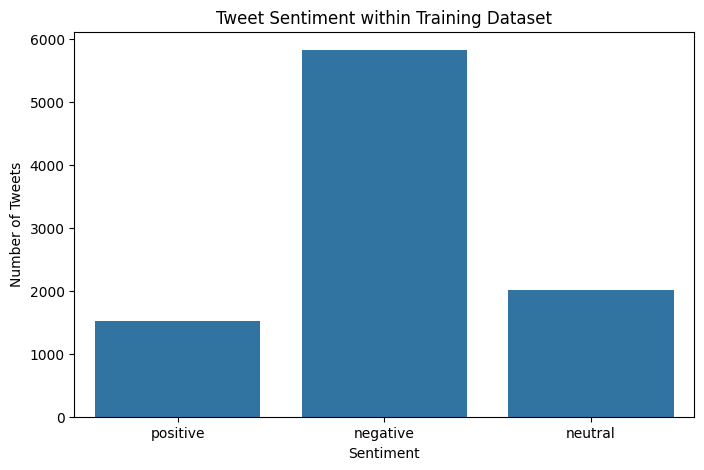

In [29]:
f, axes = plt.subplots(figsize=(8, 5))
ax = sns.countplot(x="airline_sentiment", data=train_set)
ax.set(xticklabels=['positive', 'negative', 'neutral'])
ax.set_xlabel('Sentiment')
ax.set_ylabel('Number of Tweets')
ax.set_title('Tweet Sentiment within Training Dataset')
del ax,f,axes

In [30]:
positive_sentiment = train_set[train_set.airline_sentiment == "positive"]
positive_text=positive_sentiment['text']
print('The Train Dataset contains :',positive_sentiment.shape[0],' positive tweets')
negative_sentiment = train_set[train_set.airline_sentiment == 'negative']
negative_text=negative_sentiment['text']
print('The Train Dataset contains :',negative_sentiment.shape[0],' negative tweets')
neutral_sentiment = train_set[train_set.airline_sentiment == 'neutral']
neutral_text=neutral_sentiment['text']
print('The Train Dataset contains :',neutral_sentiment.shape[0],' neutral tweets')

The Train Dataset contains : 1518  positive tweets
The Train Dataset contains : 5829  negative tweets
The Train Dataset contains : 2010  neutral tweets


In [31]:
#print(train_set.airline_sentiment.value_counts())

<ipython-input-32-d78d0fc988bc>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=train_set.airline.unique().tolist())


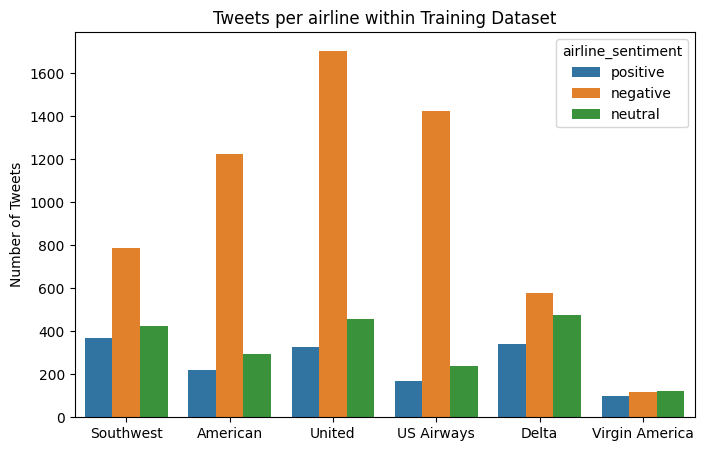

In [32]:
f, axes = plt.subplots(figsize=(8, 5))
ax = sns.countplot(x="airline", hue="airline_sentiment", data=train_set)
ax.set(xticklabels=train_set.airline.unique().tolist())
ax.set_xlabel('')
ax.set_ylabel('Number of Tweets')
ax.set_title('Tweets per airline within Training Dataset')
del ax,f,axes

In [33]:
#For removing emoticons and creating flags for both sad and happy emoticons
def happy_emoticons_removal(tweet:str) ->tuple[str,int]:
    happy = re.compile(r"([xX;:]-?[dDpP)])")
    initial = len(tweet)
    text = happy.sub(r'',tweet)
    result = ''.join([i for i in text if not i.isdigit()])
    final = len(result)
    number = 0
    for i in text:
      if i.isdigit():
        number += 1
    if( final != initial - number):
      return (result,1)
    return (result,0)

def sad_emoticons_removal(tweet:str) ->tuple[str,int]:
    happy = re.compile(r"([:]'?[/\|(])")
    initial = len(tweet)
    text = happy.sub(r'',tweet)
    result = ''.join([i for i in text if not i.isdigit()])
    final = len(result)
    number = 0
    for i in text:
      if i.isdigit():
        number += 1
    if( final != initial - number):
      return (result,1)
    return (result,0)

In [34]:
def emoticon_removal(tweet:str)-> pd.Series:
    (str_without_happy_emoji,happy_emoji_flag) = happy_emoticons_removal(tweet)
    (str_without_emoji,sad_emoji_flag) = sad_emoticons_removal(str_without_happy_emoji)
    return pd.Series([str_without_emoji,happy_emoji_flag,sad_emoji_flag])

In [35]:
train_set[['text','happy_emoji_flag','sad_emoji_flag']] = train_set.apply(lambda x: emoticon_removal(x.text),axis=1)
test_set[['text','happy_emoji_flag','sad_emoji_flag']] = test_set.apply(lambda x: emoticon_removal(x.text),axis=1)
val_set[['text','happy_emoji_flag','sad_emoji_flag']] = val_set.apply(lambda x: emoticon_removal(x.text),axis=1)

<ipython-input-35-f85e234e7c20>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[['text','happy_emoji_flag','sad_emoji_flag']] = test_set.apply(lambda x: emoticon_removal(x.text),axis=1)
<ipython-input-35-f85e234e7c20>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[['text','happy_emoji_flag','sad_emoji_flag']] = test_set.apply(lambda x: emoticon_removal(x.text),axis=1)
<ipython-input-35-f85e234e7c20>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [36]:
train_set.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,happy_emoji_flag,sad_emoji_flag
4525,570066283233972224,positive,0.9657,NaN,0.0000,Southwest,positive,magmum03,NaN,0,What an awesome flight Dallas NY. Virgin Ame...,NaN,2015-02-23 19:42:47 -0800,ny,NaN,0,0
13110,569938319024332801,negative,1.0000,Can't Tell,0.6905,American,NaN,weezerandburnie,NaN,0,You don't care about keeping your customers s...,NaN,2015-02-23 11:14:18 -0800,Belle MO,NaN,0,0
6092,568243352258236416,neutral,0.6738,NaN,0.0000,Southwest,NaN,yancey_jake,NaN,0,if a passngr requires wheelchair to gt on pla...,NaN,2015-02-18 18:59:07 -0800,NaN,NaN,0,0


<ipython-input-37-f825a3dbbe0b>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=['False','True'])
<ipython-input-37-f825a3dbbe0b>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=['True'])


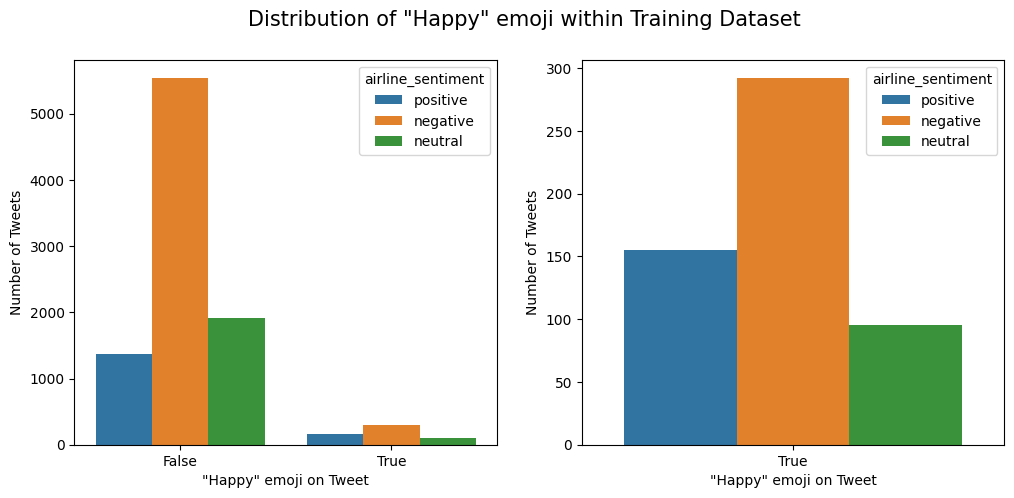

In [37]:
f, axes = plt.subplots(1,2,figsize=(12, 5))
ax = sns.countplot(x="happy_emoji_flag", hue="airline_sentiment", data=train_set,ax=axes[0])
ax.set(xticklabels=['False','True'])
ax.set_xlabel('"Happy" emoji on Tweet')
ax.set_ylabel('Number of Tweets')
ax = sns.countplot(x="happy_emoji_flag", hue="airline_sentiment", data=train_set[train_set.happy_emoji_flag==1],ax=axes[1])
ax.set(xticklabels=['True'])
ax.set_xlabel('"Happy" emoji on Tweet')
ax.set_ylabel('Number of Tweets')
f.suptitle('Distribution of "Happy" emoji within Training Dataset',fontsize=15)
del ax,f,axes

<ipython-input-38-8df11df7940e>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=['False','True'])
<ipython-input-38-8df11df7940e>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=['True'])


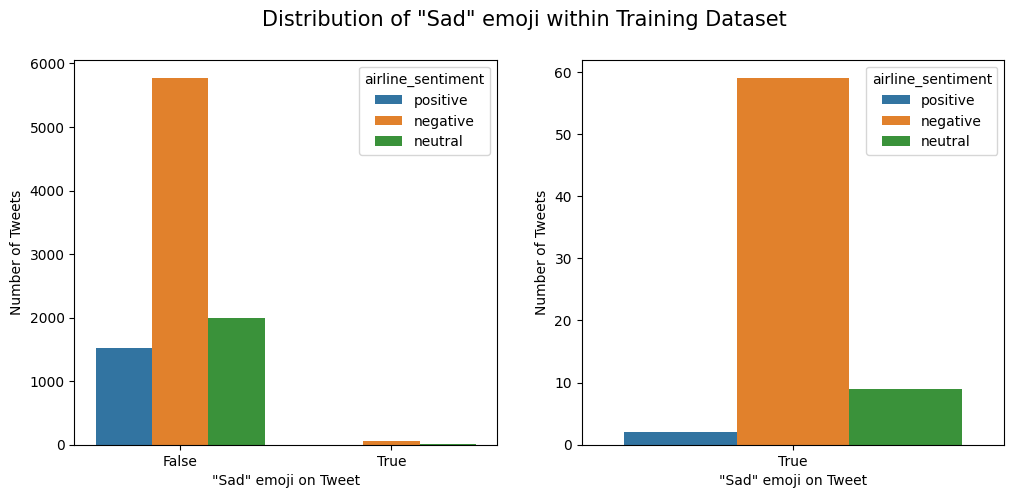

In [38]:
f, axes = plt.subplots(1,2,figsize=(12, 5))
ax = sns.countplot(x="sad_emoji_flag", hue="airline_sentiment", data=train_set,ax=axes[0])
ax.set(xticklabels=['False','True'])
ax.set_xlabel('"Sad" emoji on Tweet')
ax.set_ylabel('Number of Tweets')
ax = sns.countplot(x="sad_emoji_flag", hue="airline_sentiment", data=train_set[train_set.sad_emoji_flag==1],ax=axes[1])
ax.set(xticklabels=['True'])
ax.set_xlabel('"Sad" emoji on Tweet')
ax.set_ylabel('Number of Tweets')
f.suptitle('Distribution of "Sad" emoji within Training Dataset',fontsize=15)
del ax,f,axes

In [39]:
train_set.head(2)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,happy_emoji_flag,sad_emoji_flag
4525,570066283233972224,positive,0.9657,NaN,0.0000,Southwest,positive,magmum03,NaN,0,What an awesome flight Dallas NY. Virgin Ame...,NaN,2015-02-23 19:42:47 -0800,ny,NaN,0,0
13110,569938319024332801,negative,1.0000,Can't Tell,0.6905,American,NaN,weezerandburnie,NaN,0,You don't care about keeping your customers s...,NaN,2015-02-23 11:14:18 -0800,Belle MO,NaN,0,0


In [40]:
def stop_word_and_stemming(tweet:str):
    tknzr = TweetTokenizer(preserve_case=False,strip_handles=True, reduce_len=True)
    myStemmer = PorterStemmer()
    tweet = tknzr.tokenize(tweet)
    stop = stopwords.words('english')
    new_list = [myStemmer.stem(word) for word in tweet if word not in stop]
    tweet = ' '.join(new_list)
    return tweet

In [41]:
train_set['text'] = train_set['text'].apply(stop_word_and_stemming)
test_set['text'] = test_set['text'].apply(stop_word_and_stemming)
val_set['text'] = val_set['text'].apply(stop_word_and_stemming)

<ipython-input-41-30516ddc7618>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['text'] = test_set['text'].apply(stop_word_and_stemming)


In [42]:
#For removing punctuation
def remove_punctuations(text:str):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [43]:
train_set['text'] = train_set['text'].apply(remove_punctuations)
test_set['text'] = test_set['text'].apply(remove_punctuations)
val_set['text'] = val_set['text'].apply(remove_punctuations)

<ipython-input-43-07d13bfcbff7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['text'] = test_set['text'].apply(remove_punctuations)


In [44]:
train_set.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,happy_emoji_flag,sad_emoji_flag
4525,570066283233972224,positive,0.9657,NaN,0.0000,Southwest,positive,magmum03,NaN,0,awesom flight dalla ny virgin america refus b...,NaN,2015-02-23 19:42:47 -0800,ny,NaN,0,0
13110,569938319024332801,negative,1.0000,Can't Tell,0.6905,American,NaN,weezerandburnie,NaN,0,care keep custom safe least care sister,NaN,2015-02-23 11:14:18 -0800,Belle MO,NaN,0,0
6092,568243352258236416,neutral,0.6738,NaN,0.0000,Southwest,NaN,yancey_jake,NaN,0,passngr requir wheelchair gt plane sit exit ro...,NaN,2015-02-18 18:59:07 -0800,NaN,NaN,0,0


In [49]:
def decode_date(date_str)->pd.Series:
  aux = date_str.replace(' -0800','')
  date_utc = datetime.strptime(aux,"%Y-%m-%d %H:%M:%S")
  return pd.Series([date_utc.weekday(),date_utc.day,date_utc.hour])

In [56]:
train_set[['week_day','day','hour']] =train_set['tweet_created'].apply(decode_date)
test_set[['week_day','day','hour']] =test_set['tweet_created'].apply(decode_date)
val_set[['week_day','day','hour']] =val_set['tweet_created'].apply(decode_date)

<ipython-input-56-021a89085897>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[['week_day','day','hour']] =test_set['tweet_created'].apply(decode_date)
<ipython-input-56-021a89085897>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[['week_day','day','hour']] =test_set['tweet_created'].apply(decode_date)
<ipython-input-56-021a89085897>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [55]:
train_set.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,happy_emoji_flag,sad_emoji_flag,week_day,day,hour
4525,570066283233972224,positive,0.9657,NaN,0.0000,Southwest,positive,magmum03,NaN,0,awesom flight dalla ny virgin america refus b...,NaN,2015-02-23 19:42:47 -0800,ny,NaN,0,0,0,23,19
13110,569938319024332801,negative,1.0000,Can't Tell,0.6905,American,NaN,weezerandburnie,NaN,0,care keep custom safe least care sister,NaN,2015-02-23 11:14:18 -0800,Belle MO,NaN,0,0,0,23,11
6092,568243352258236416,neutral,0.6738,NaN,0.0000,Southwest,NaN,yancey_jake,NaN,0,passngr requir wheelchair gt plane sit exit ro...,NaN,2015-02-18 18:59:07 -0800,NaN,NaN,0,0,2,18,18


In [57]:
train_set.drop(['tweet_created'],axis=1,inplace=True)
test_set.drop(['tweet_created'],axis=1,inplace=True)
val_set.drop(['tweet_created'],axis=1,inplace=True)

<ipython-input-57-1e9b21aab6fc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set.drop(['tweet_created'],axis=1,inplace=True)


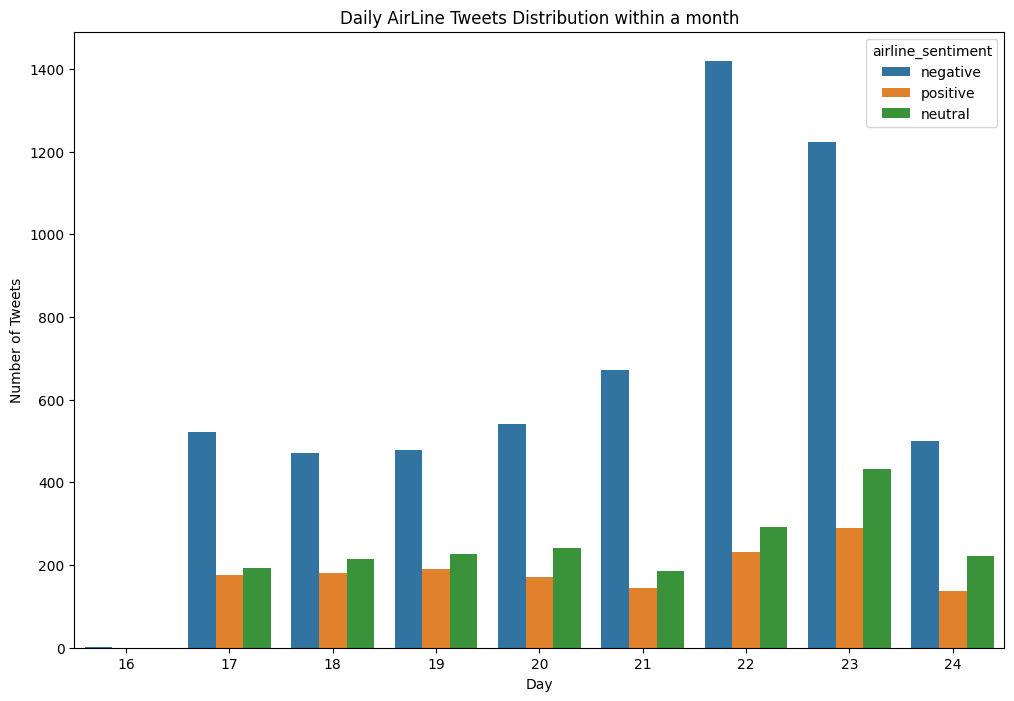

In [58]:
fig, axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x="day", hue="airline_sentiment", data=train_set)
ax.set_xlabel('Day')
ax.set_ylabel('Number of Tweets')
ax.set_title('Daily AirLine Tweets Distribution within a month')
del ax,fig,axes

<ipython-input-59-0222784239c7>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])


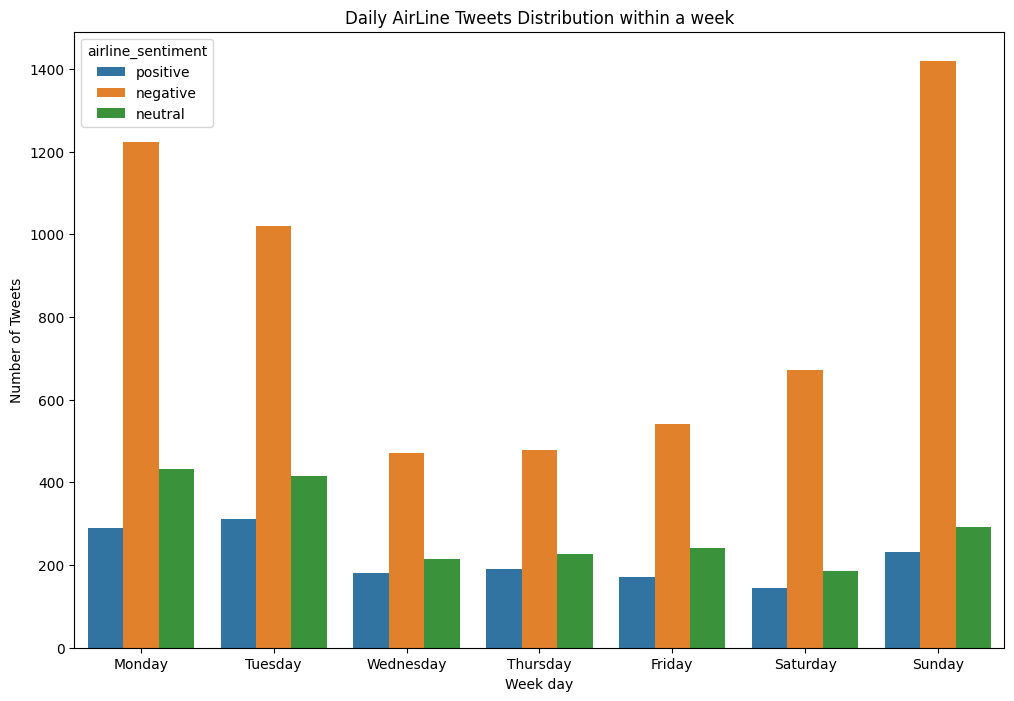

In [59]:
fig, axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x="week_day", hue="airline_sentiment", data=train_set)
ax.set_xlabel('Week day')
ax.set(xticklabels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
ax.set_ylabel('Number of Tweets')
ax.set_title('Daily AirLine Tweets Distribution within a week')
del ax,fig,axes